In [129]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import solve, cholesky, inv
from numpy.random import multivariate_normal

from scipy.optimize import minimize
from scipy.stats import norm

from functools import partial

%matplotlib inline

In the basic form we have $K = k(X_{\text{train}}, X_{\text{train}}), K_* = k(X_{\text{train}}, X_{\text{test}}), K_{**} = k(X_{\text{test}}, X_{\text{test}})$, which gives us the following posterior

$$
\begin{align}
    \mu &= K_* K^{-1} y \\
    var &= K_{**} - K_* K^{-1} K_*^T.
\end{align}
$$

We can also write

$$
\begin{align}
    L &= cholesky(K) \\
    \alpha &= L^T \backslash (L \backslash y) \\
    \mu &= K_*^T \alpha \\
    v &= L \backslash K_* \\
    var &= K_{**} - v^T v,
\end{align}
$$

and we also know that

$$
(L \backslash K_*)^T (L \backslash y) = K_*^T (L^T \backslash (L \backslash y)) = K_* K^{-1} y
$$

## Utils

In [101]:
def plots(*plots, n_row=3, figsize=(15,4)):
    num_rows = len(plots) // n_row + 1
      
    plt.figure(figsize=figsize)
        
    for i, plot in enumerate(plots):
        plt.subplot(num_rows, n_row, i+1)
        plt.imshow(plot)
    
    plt.show()

def plot_gp(mu, cov, X, X_train=None, y_train=None, num_samples=3, figsize=(7,4), figure=True):
    std = 2*np.sqrt(np.diag(cov)) # 1.96?
    
    if figure:
        plt.figure(figsize=figsize)

    plt.fill_between(X, mu + std, mu - std, alpha=0.1)
    plt.plot(X, mu, label="Mean")
    
    samples = multivariate_normal(mu, cov, size=num_samples)
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=0.7, ls="--", label=f"Sample {i+1}", color="black")
        
    if X_train is not None:
        plt.plot(X_train, y_train, "rx", lw=2)
    
    plt.legend()

## Kernels

In [88]:
def sqexp(x, y, l=1):
    return np.exp(-.5 * l * (x*x + y*y - 2*x*y))

def k(x, y=None, kernel=sqexp):
    if y is None:
        y = x
        
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
        
    return kernel(*np.meshgrid(y,x)) + 1e-12*np.eye(x.shape[0], y.shape[0])

## GP regression (ignoring noisy for now)

We condition on the training data and compute the posterior for the test data $X_{\text{test}}$. Since the posterior is Gaussian, it is fully defined by its mean and covariance, which we can compute in closed form

$$
\begin{align}
    \mu_* &= K_*^T K_*^{-1} y \\
    \Sigma_* &= K_{**} - K_*^T K_*^{-1} K_*
\end{align}
$$

In [164]:
def gp_reg(X_train, y_train, X_test, kernel=sqexp, return_std=False):
    n = len(X_test)
    
    K = k(X_train, X_train, kernel)
    K_s = k(X_train, X_test, kernel)
    K_ss = k(X_test, X_test, kernel)
    
    stable_eye = 1e-4 * np.eye(len(K)) # Just for numerical stability?
    
    K_inv = inv(K + stable_eye)
    
    # L = cholesky(K + stable_eye)    
    # alpha = solve(L.T, solve(L, y_train))
    # mu = K_s.T @ alpha
    
    mu = K_s.T @ K_inv @ y_train
    cov = K_ss - K_s.T @ K_inv @ K_s
    
    if return_std:
        return mu, np.sqrt(np.diag(cov))
    else:
        return mu, cov

In [165]:
X_train = np.array([0,0.3,2,4])
y_train = np.sin(X_train)

X = np.arange(min(X_train) - 0.5, max(X_train) + 0.5, step=0.1)

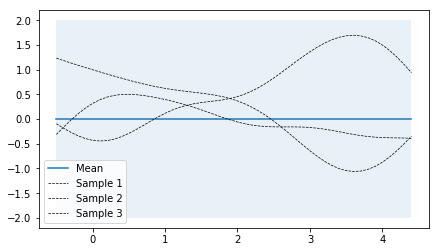

In [166]:
plot_gp(np.zeros(len(X)), k(X, X), X)

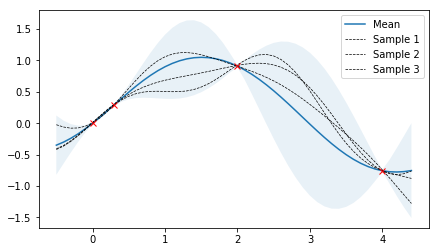

In [167]:
# mu, cov = gp_reg(X_train, y_train, X)


plot_gp(*gp_reg(X_train, y_train, X), X, X_train, y_train)

## Kernel params

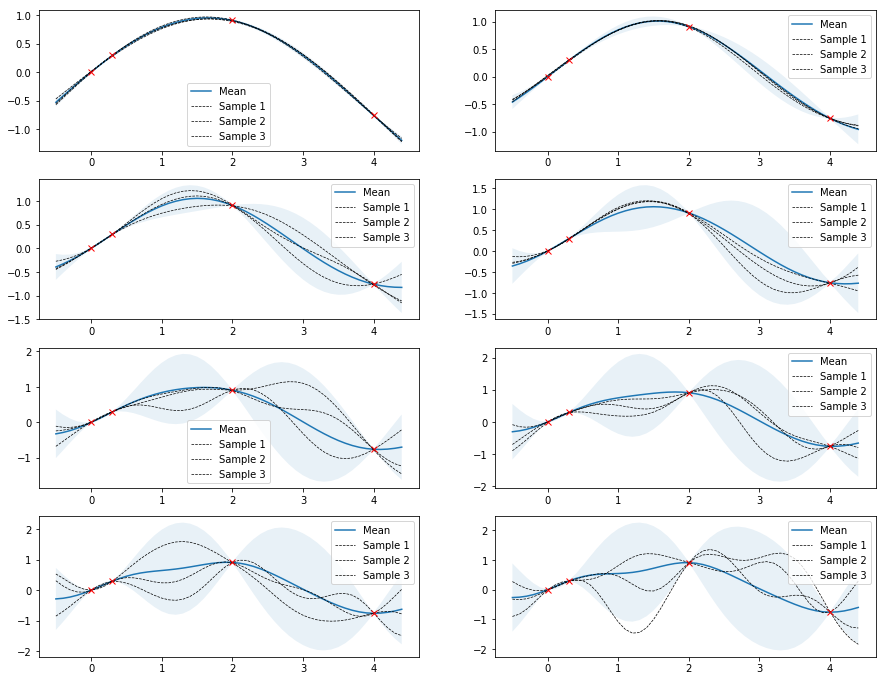

In [168]:
params = [0.1, 0.3, 0.6, 0.9, 1.5, 2, 2.5, 3]

plt.figure(figsize=(15,15))
for i, l in enumerate(params):
    num_rows = len(params) // 2 + 1

    plt.subplot(num_rows, 2, i+1)    
    plot_gp(*gp_reg(X_train, y_train, X, kernel=partial(sqexp, l=l)), X, X_train, y_train, figure=False)

## Optimizing kernel parameters

$$
\begin{align}
    \log p(y|X) &= \log N(y|0, K_y) \\
                &= -\frac{1}{2} y^T K_y^{-1} y - \frac{1}{2} \log |K_y| - \frac{N}{2} \log(2 \pi)
\end{align}
$$

In [169]:
def nll_fn(X_train, y_train, noise, kernel=sqexp):
    def step(theta):
        K = k(X_train, X_train, kernel=partial(sqexp, l=theta[0])) # + noise**2 * np.eye(len(X_train))
        
        t1 = 0.5 * y_train @ inv(K) @ y_train
        t2 = 0.5 * np.linalg.det(K)
        t3 = 0.5 * len(X_train) * np.log(2 * np.pi)
        
        return t1 + t2 + t3
    
    return step

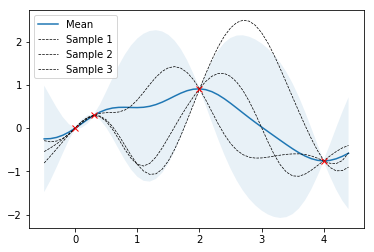

In [170]:
noise = 0.4

res = minimize(nll_fn(X_train, y_train, noise), [1], bounds=[(1e-5, None)], method="L-BFGS-B")
l_opt = res.x

k_opt = partial(sqexp, l=l_opt)

plot_gp(*gp_reg(X_train, y_train, X, kernel=k_opt), X, X_train, y_train, figure=False)

# Bayesian Optimization

http://krasserm.github.io/2018/03/21/bayesian-optimization/

In [171]:
def plot_approximation(X, Y, X_sample, y_sample, X_next=None, show_legend=False):
    mu, std = gp_reg(X_sample, y_sample, X, return_std=True)
    
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    plt.plot(X, Y, 'y--', lw=1, label='Noise-free objective')
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    
        
def plot_convergence(X_sample, y_sample, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_sample[n_init:].ravel()
    y = y_sample[n_init:].ravel()
    r = range(1, len(x)+1)
    
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.maximum.accumulate(y)
    
    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, 'bo-')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')

    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, 'ro-')
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')

In [172]:
bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

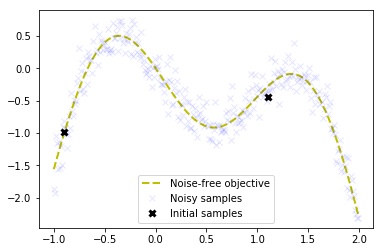

In [173]:
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

In [174]:
def expected_improvement(X, X_sample, y_sample, xi=0.01):
    mu, sigma = gp_reg(X_sample, y_sample, X, return_std=True)
    mu_sample, sigma_sample = gp_reg(X_sample, y_sample, X_sample, return_std=True)
    
    sigma = sigma.reshape(-1, X_sample.shape[1])
    
    # Needed for noise-based model,
    # otherwise use np.max(y_sample).
    # See also section 2.4 in [...]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

In [175]:
def propose_location(acquisition, X_sample, y_sample, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
    
    acquisition: Acquisition function.
    X_sample: Sample locations (n x d).
    y_sample: Sample values (n x 1).
    
    Returns: Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, y_sample)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

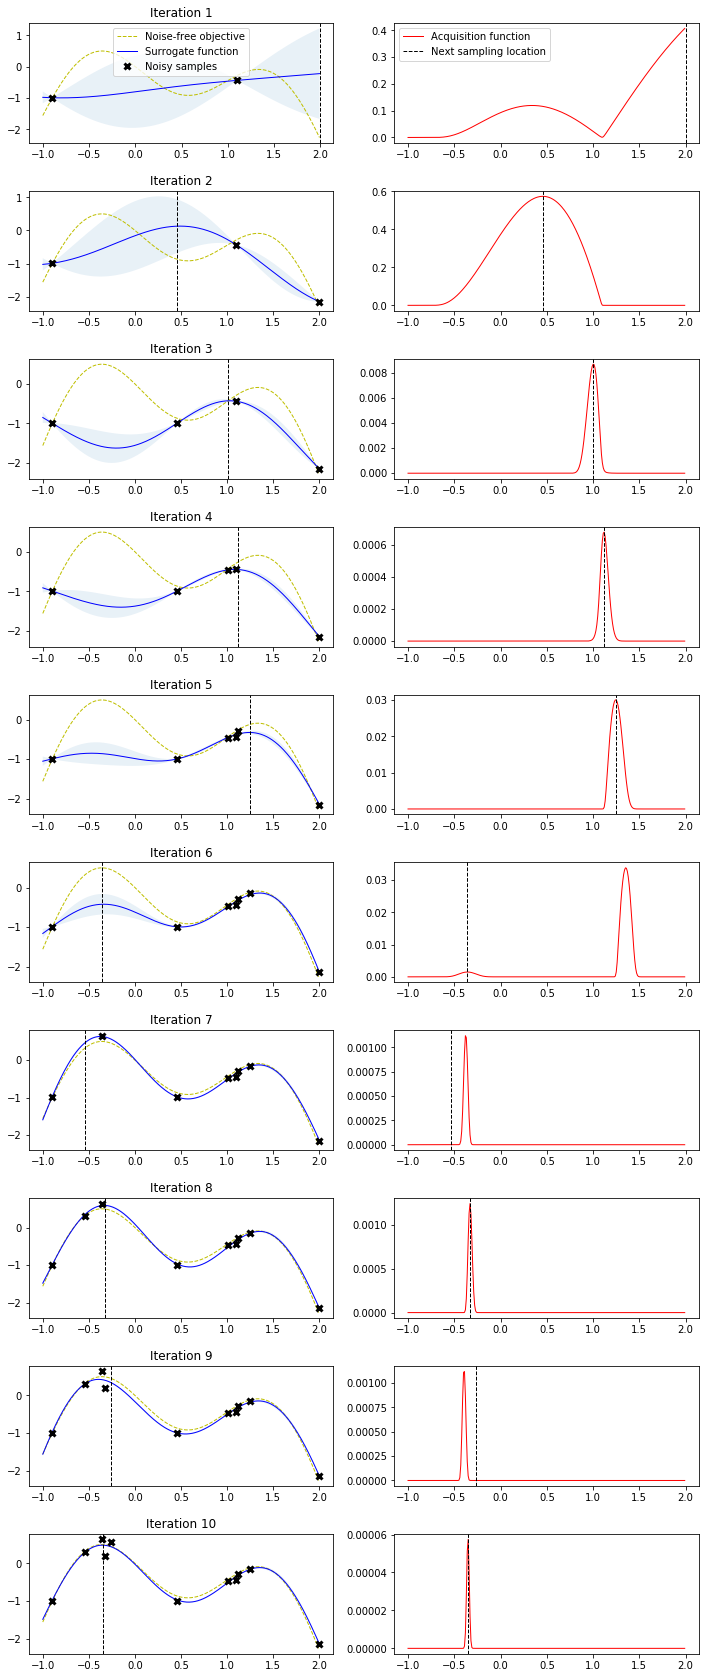

In [176]:
X_sample = X_init
y_sample = Y_init

# Number of iterations
n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, y_sample, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(X, Y, X_sample, y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, y_sample), X_next, show_legend=i==0)
    
    X_sample = np.vstack((X_sample, X_next))
    y_sample = np.vstack((y_sample, Y_next))

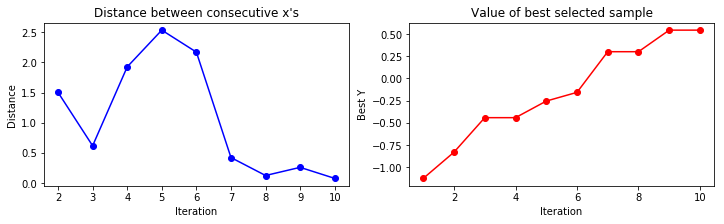

In [141]:
plot_convergence(X_sample, Y_sample)